# Red neuronal para predecir poses

## Importar librerias

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

from keras import layers,callbacks
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2025-07-16 15:37:46.401764: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 15:37:46.409330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752701866.417956   78605 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752701866.420465   78605 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752701866.427067   78605 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Preparar datos

In [2]:
DATA      = Path("../data").resolve()
TRAIN_VAL = DATA / "train_val_csv"
TEST      = DATA / "test_csv"
Salida    = Path("dataset_completo.csv")
#
# Unir los csvs de entrenamiento para hacer uno solo
csvs = [p for p in DATA.rglob("*.csv") if p.parent==TRAIN_VAL and p.stem!=Salida.stem]
df_train =pd.concat((pd.read_csv(f) for f in csvs),ignore_index=True)
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_train.to_csv(TRAIN_VAL/Salida, index=False, float_format="%.6f")

X_train_val= df_train.drop(columns=['label'])
Y_train_val= df_train['label']

poses_lb   =LabelBinarizer()
Y_oh_train_val =poses_lb.fit_transform(Y_train_val)
print(Y_oh_train_val,Y_train_val)

#
# Unir los csvs de prueba para hacer uno solo
csvs = [p for p in DATA.rglob("*.csv") if p.parent==TEST and p.stem!=Salida.stem]
df_test =pd.concat((pd.read_csv(f) for f in csvs),ignore_index=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)
df_test.to_csv(TEST/Salida, index=False, float_format="%.6f")

X_test= df_test.drop(columns=['label'])
Y_test= df_test['label']

Y_oh_test =poses_lb.fit_transform(Y_test)
print(Y_oh_test,Y_test)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]] 0                 OTRO
1                 OTRO
2                 OTRO
3                 OTRO
4                 OTRO
             ...      
2080    POSICION_FETAL
2081    POSICION_FETAL
2082    POSICION_FETAL
2083    POSICION_FETAL
2084    POSICION_FETAL
Name: label, Length: 2085, dtype: object
[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]] 0                 OTRO
1                 OTRO
2                 OTRO
3                 OTRO
4                 OTRO
             ...      
1461    POSICION_FETAL
1462    POSICION_FETAL
1463    POSICION_FETAL
1464    POSICION_FETAL
1465    POSICION_FETAL
Name: label, Length: 1466, dtype: object


## Preparar datos (Test)

## Dividir datos en:
* Entrenamiento = 80%
* Validación = 20%

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, Y_oh_train_val, test_size=0.20, stratify=Y_train_val, random_state=42)

## Definicion y compilacion de Red Neuronal

In [4]:
n_features = X_train.shape[1]
n_classes  = y_train.shape[1]
#print(n_features,n_classes)
#
model = Sequential([
    layers.Input( shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

I0000 00:00:1752701867.838477   78605 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4958 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Entrenamiento

In [5]:
checkpoint = callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    verbose=2)


Epoch 1/100


I0000 00:00:1752701868.888290   78763 service.cc:152] XLA service 0x7a39a800ee60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752701868.888302   78763 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-16 15:37:48.906381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752701869.004062   78763 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752701870.265128   78763 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-07-16 15:37:50.867637: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1496', 140 bytes spill stores, 140 bytes spill loads



7/7 - 4s - 533ms/step - accuracy: 0.5540 - loss: 1.1675 - val_accuracy: 0.2158 - val_loss: 1.4017
Epoch 2/100
7/7 - 0s - 9ms/step - accuracy: 0.7614 - loss: 0.6459 - val_accuracy: 0.2110 - val_loss: 1.4192
Epoch 3/100
7/7 - 0s - 10ms/step - accuracy: 0.8327 - loss: 0.4800 - val_accuracy: 0.2230 - val_loss: 1.3771
Epoch 4/100
7/7 - 0s - 11ms/step - accuracy: 0.8861 - loss: 0.3620 - val_accuracy: 0.2398 - val_loss: 1.3018
Epoch 5/100
7/7 - 0s - 11ms/step - accuracy: 0.8897 - loss: 0.3245 - val_accuracy: 0.2518 - val_loss: 1.2473
Epoch 6/100
7/7 - 0s - 11ms/step - accuracy: 0.9269 - loss: 0.2452 - val_accuracy: 0.2878 - val_loss: 1.1998
Epoch 7/100
7/7 - 0s - 11ms/step - accuracy: 0.9305 - loss: 0.2208 - val_accuracy: 0.3333 - val_loss: 1.1468
Epoch 8/100
7/7 - 0s - 11ms/step - accuracy: 0.9430 - loss: 0.1919 - val_accuracy: 0.5204 - val_loss: 1.0938
Epoch 9/100
7/7 - 0s - 11ms/step - accuracy: 0.9442 - loss: 0.1724 - val_accuracy: 0.6595 - val_loss: 1.0326
Epoch 10/100
7/7 - 0s - 11ms/st

## Evaluación

In [6]:
test_loss, test_acc = model.evaluate(X_test, Y_oh_test, verbose=0)
print(f"Accuracy en test: {test_acc:.3f}")


y_pred = model.predict(X_test)
cm = confusion_matrix(Y_oh_test.argmax(1), y_pred.argmax(1))
print(cm)
print(classification_report(Y_oh_test.argmax(1), y_pred.argmax(1), target_names=poses_lb.classes_))

#Distancia cosenoidal entre los datos (Por cada clase)
#Tomar 10 frames de cada segundo

Accuracy en test: 0.939
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[332  22   0   0]
 [  5 378   0   0]
 [  5  29 449   4]
 [ 11   5   8 218]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       0.94      0.94      0.94       354
         FIRMES       0.87      0.99      0.93       383
           OTRO       0.98      0.92      0.95       487
 POSICION_FETAL       0.98      0.90      0.94       242

       accuracy                           0.94      1466
      macro avg       0.94      0.94      0.94      1466
   weighted avg       0.94      0.94      0.94      1466



## Graficas de resultados

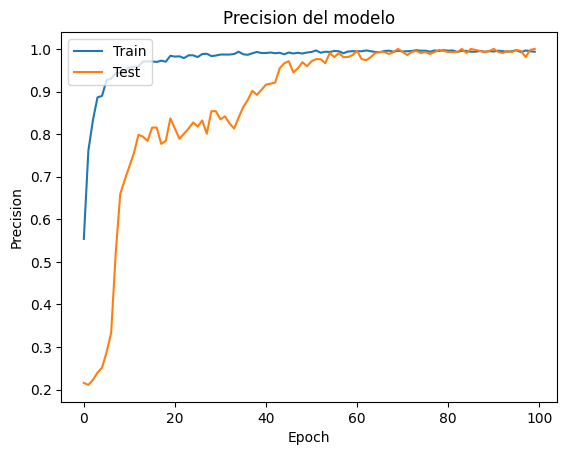

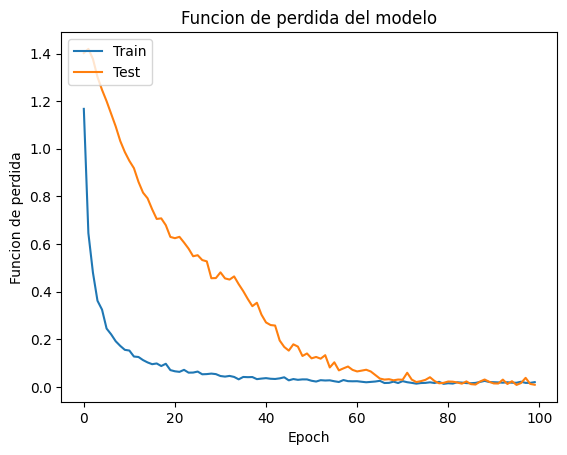

In [7]:
#Evaluar resultados
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Funcion de perdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida del modelo')
plt.ylabel('Funcion de perdida')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Uso del modelo para predicción

In [14]:
from ExtraeFrame import IMAGEN

imagen=IMAGEN("Fotos/foto8.jpeg")
x_new=imagen.extrae(muestra=True)
x_new=np.array([x_new])

prediccion  = model.predict(x_new)
print (prediccion)
label  = poses_lb.inverse_transform(prediccion)
print(label)


I0000 00:00:1752702286.309830   78605 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752702286.332338   94098 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.144.03), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1752702286.367786   94067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752702286.436751   94085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Analizando Imagen
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[9.9996591e-01 2.0055343e-06 3.2124466e-05 4.5192348e-08]]
['BRAZOS_CRUZADOS']
